# Variational Ladder Autoencoders

## Summary
This notebook describes and implements a [Variational Ladder Autoencoder (VLAE)](https://arxiv.org/abs/1702.08396). Similar to a Variational Autoencoder (VAE), a VLAE learns to both encode a data point into a latent variable and to decode the latent variable into a reconstruction of the data point. Unlike a VAE, a VLAE outputs latent variables at multiple layers of the encoding network, rather than feeding through each layer to one latent variable. The change allows for finer features to be disentangled from coarser features.

The architecture implemented here is purely experimental. The original implementation can be found [here](https://github.com/ermongroup/Variational-Ladder-Autoencoder).

In [33]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F

#### VLAE Class

The class used here is similar to the VAE class used in my [VAE notebook](./Basic_VAE.ipynb). However, the 'generate_similar' method now has 

In [34]:
class VLAE(nn.Module):
    '''
    Creates a Variation Autoencoder
    
    :param encoder_network: (nn.Module)
    :param decoder_network: (nn.Module)
    :param loss: (str, opt) Either 'kl' or 'mc'. Sets how to calculate loss.
    '''
    def __init__(self, encoder_network, decoder_network, loss='mc'):
        super(VLAE, self).__init__()
        
        self.add_module('encode', encoder_network)
        self.add_module('generate', decoder_network)
        self.loss = loss.lower()
        
    def forward(self, input):
        '''
        Passes forward through encoder to create a sample latent
        representation, then decodes that representation.
        
        :param input: (t.Tensor) 
        :return: (t.Tensor) Reconstruction of x and it's latent loss
        '''
        mean, scale = self.encode(input)
        eps = t.randn_like(mean)
        z = mean+scale*eps
        if self.training:
            if self.loss == 'mc':
                loss = self.MC(z, eps, scale)
            elif self.loss == 'kl':
                loss = -self.KL(mean, scale)
        else:
            loss = t.tensor(0)
        
        return self.generate(z), loss

    def generate_similar(self, input, noise=True):
        '''
        Creates similar examples by encoding the observation and then decoding the 
        latent observation. If noise is True, then it uses the latent variable
        z = mean+eps*scale. Otherwise, z = mean.

        :param input: (t.Tensor)
        :param noise: (Bool, opt)
        :return: (torch.Tensor) Reconstruction of input
        '''
        mean, scale = self.encode(input)

        if noise:
            eps = t.randn_like(mean)
            z = mean+scale*eps
        else:
            z = mean

        return self.generate(z)
    
    @staticmethod
    def MC(z, eps, scale):
        '''
        Computes fully monte carlo loss for the statistics layer.
        
        :param z: (t.Tensor) latent variable
        :param eps: (t.Tensor) random noise
        :param scale: (t.Tensor) scale (or standard deviation)
        '''     
        loss = t.sum(z.pow(2)/2-(eps.pow(2)/2+scale.log()), 1)
        return loss.mean()

#### Utility layer
This layer reshapes the input. This is done for convenience when using `nn.Sequential`.

In [35]:
class ReshapeLayer(nn.Module):
    '''
    Reshapes the input to be the output using view. Shapes are checked
    on forward pass to verify that they are compatible.

    :param view_shape: The shape to cast the input to. Given a batch
        input of shape (n, _) will be cast to (n, view_shape).
    '''
    def __init__(self, view_shape):
        super(ReshapeLayer, self).__init__()
        self.view_shape = view_shape

    def forward(self, x):
        '''
        Reshapes x to initialized shape.
        :param x: (t.Tensor)
        :return: (t.Tensor)
        '''
        output_shape = (x.shape[0],) + self.view_shape
        assert self.dimension(x.shape) == self.dimension(output_shape), \
            '{0} and {1} are not compatabile'.format(x.shape, output_shape)
        return x.view(output_shape)

    @staticmethod
    def dimension(shape):
        #Helper function for checking dimensions
        out = 1
        for s in shape:
            out *= s
        return out

In [36]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.kaiming_normal_(m.weight, a=1)

In [37]:
class FeatureEncoder(nn.Module):
    def __init__(self, in_channels, hidden_size, image_size, z_size, drop_prob=0.1):
        super(FeatureEncoder, self).__init__()
        self.feature_map = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels*image_size**2, hidden_size),
            nn.SELU(),
            nn.AlphaDropout(p=drop_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.SELU(),
        )
        self.mean = nn.Linear(hidden_size, z_size)
        self.log_var = nn.Linear(hidden_size, z_size)
        
        self.feature_map.apply(init_weights)
    
    def forward(self, input):
        x = self.feature_map(input)
        mean = self.mean(x)
        scale = (self.log_var(x)/2).exp()
        return mean, scale

In [38]:
class ConvDown(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvDown, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding),
            nn.SELU()
        )
        self.conv.apply(init_weights)
        
    def forward(self, input):
        return self.conv(input)

class Encoder(nn.Module):
    def __init__(self, channel_factor, hidden_size, z_size, drop_prob):
        super(Encoder, self).__init__()
        self.conv1 = ConvDown(3, channel_factor, 4, 2, 1)
        self.feat1 = FeatureEncoder(channel_factor, hidden_size, 16, z_size, drop_prob)
        self.conv2 = ConvDown(channel_factor, 2*channel_factor, 4, 2, 1)
        self.feat2 = FeatureEncoder(2*channel_factor, hidden_size, 8, z_size, drop_prob)
        self.conv3 = ConvDown(2*channel_factor, 4*channel_factor, 4, 2, 1)
        self.feat3 = FeatureEncoder(4*channel_factor, hidden_size, 4, z_size, drop_prob)
        self.conv4 = ConvDown(4*channel_factor, 8*channel_factor, 4, 1)
        self.feat4 = FeatureEncoder(8*channel_factor, hidden_size, 1, z_size, drop_prob)
    
    def forward(self, input):
        x = self.conv1(input)
        mean1, scale1 = self.feat1(x)
        x = self.conv2(x)
        mean2, scale2 = self.feat2(x)
        x = self.conv3(x)
        mean3, scale3 = self.feat3(x)
        x = self.conv4(x)
        mean4, scale4 = self.feat4(x)
        means = t.cat([mean1, mean2, mean3, mean4], 1)
        scales = t.cat([scale1, scale2, scale3, scale4], 1)
        return means, scales

The following generator uses several layers of latent variables, which are added at each convolution. Originally I tried concatenation, but this failed to produce convincing images after 50 epochs.

In [39]:
class FeatureDecoder(nn.Module):
    def __init__(self, z_size, hidden_size, image_size, out_channels, drop_prob=0.1):
        super(FeatureDecoder, self).__init__()
        self.feature_map = nn.Sequential(
            nn.Linear(z_size, hidden_size),
            nn.SELU(),
            nn.AlphaDropout(p=drop_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.SELU(),
            nn.AlphaDropout(p=drop_prob),
            nn.Linear(hidden_size, out_channels*image_size**2),
            nn.SELU(),
        )
        self.out_shape = (out_channels, image_size, image_size)
        self.feature_map.apply(init_weights)
    
    def forward(self, input):
        x = self.feature_map(input)
        return x.reshape((-1, *self.out_shape))
    
class ConvUp(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvUp, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.SELU()
        )
        self.conv.apply(init_weights)
        
    def forward(self, input):
        return self.conv(input)
    
class Decoder(nn.Module):
    def __init__(self, channel_factor, hidden_size, z_size, drop_prob):
        super(Decoder, self).__init__()
        self.z_size = z_size
        self.feat1 = FeatureDecoder(z_size, hidden_size, 1, 8*channel_factor, drop_prob)
        self.conv1 = ConvUp(8*channel_factor, 4*channel_factor, 4, 1)
        self.feat2 = FeatureDecoder(z_size, hidden_size, 4, 4*channel_factor, drop_prob)
        self.conv2 = ConvUp(4*channel_factor, 2*channel_factor, 4, 2, 1)
        self.feat3 = FeatureDecoder(z_size, hidden_size, 8, 2*channel_factor, drop_prob)
        self.conv3 = ConvUp(2*channel_factor, channel_factor, 4, 2, 1)
        self.feat4 = FeatureDecoder(z_size, hidden_size, 16, channel_factor, drop_prob)
        self.conv4 = nn.ConvTranspose2d(channel_factor, 3, 4, 2, 1)
    
    def forward(self, input):
        #Split into 4 equally sized latent variables
        z1, z2, z3, z4 = input.split(self.z_size, 1)
        
        x1 = self.feat1(z1)
        x2 = self.feat2(z2)
        x3 = self.feat3(z3)
        x4 = self.feat4(z4)
        
        x = self.conv1(x1)
        x = self.conv2(x+x2)
        x = self.conv3(x+x3)
        return t.tanh(self.conv4(x+x4))

### Building the network

Here we build the encoder and decoder. This is done using the Sequential function. The encoder network needs to end with the statistics layer. The decoder is just a standard decoder. The size of the hidden layers are chosen experimentally.

The encoder and decoder networks are based on the Deep Convolution GAN architecture. The images are encoded using strided convolutions with dropout, batch normalization and Leaky ReLU units. The latent encoding is then decoded using strided convolution tranpositions with dropout, batch normalization and ReLU units.

In [40]:
latent_dim = 16
channel_factor = 16
drop_prob = 0.1

#Build networks
encoder_net = Encoder(channel_factor, latent_dim, latent_dim, drop_prob)

decoder_net = Decoder(channel_factor, latent_dim, latent_dim, drop_prob)

model = VLAE(encoder_net, decoder_net)

### Dataset

For this notebook, we use the MNIST dataset. A drop-in replacement that can be used is the FashionMNIST dataset.

In [41]:
import torch.utils.data as data
import torchvision.datasets as datasets
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import make_grid, save_image

transforms = Compose([ToTensor(), Normalize([0.5], [0.5])])
training_set = datasets.SVHN(root='./data/', split='train', download=True, transform=transforms)
batch_size = 128
training_loader = data.DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: ./data/train_32x32.mat


### Optimizing the network parameters

Now that we have the network, we need to find parameters that minimizes our estimate above. In order to accomplish this, we run the model over a batch of observations, and then compute the loss. Using stochastic gradient descent methods, we can then find a change of parameters that will (usually) decrease the loss.

More explicitely, the encoder network takes in an observation $x$ and produces statistics, $(\mu, \Sigma)$, for the latent variable, $z$. Using the Monte Carlo loss or KL divergence above, we can determine a loss for the encoder. We then use $z$ to generate a reconstruction of the observation, $\hat{x}$. By comparing $x$ and $\hat{x}$, we have a loss for the decoder. The total loss of the variational autoencoder is the sum of these two losses. Because we are minimizing the sum, there is no guarantee that both components will decrease. In fact, the encoder loss typically increases while the decoder loss typically decreases. This is seen in the training summary printed below.

In [42]:
def mse_loss(input, target):
    loss = (input-target).pow(2)/2
    #Return batch average
    return loss.mean(0).sum()

In [43]:
def train_vae(model, data_loader, optimizer, use_gpu=True):
    average_recon = 0
    average_latent = 0
    for n_batch, (x, _) in enumerate(data_loader):
        if use_gpu:
            x = x.cuda()
        
        x_pred, latent_loss = model(x)
        
        #compute -log p(x|z)
        recon_loss = mse_loss(x, x_pred)
        loss = recon_loss+latent_loss
        
        #Compute average
        average_latent += float(latent_loss-average_latent)/(n_batch+1)
        average_recon += float(recon_loss-average_recon)/(n_batch+1)

        #Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Print percent complete
        print(percent_complete.format(batch_size*n_batch/n_data), end='')
        
    return average_recon, average_latent

In [44]:
epochs = 5
use_gpu = t.cuda.is_available()
model.train()

#Add to gpu before making the optimizer
if use_gpu:
    model.cuda(0)

optimizer = t.optim.Adamax(model.parameters())

epoch_summary_text = '\rEpoch {0}/{1}'
loss_summary_text = '{0} loss: {1:.5}'

percent_complete = '\r{0:.1%}'

n_data = len(training_set)
for epoch in range(epochs):
    recon_loss, latent_loss = train_vae(model, training_loader, optimizer, use_gpu)

    #Create summary loss
    epoch_summary = epoch_summary_text.format(epoch+1, epochs)
    latent_summary = loss_summary_text.format('latent', latent_loss)
    recon_summary = loss_summary_text.format('recon', recon_loss)
    total_summary = loss_summary_text.format('total', latent_loss+recon_loss)
    print(epoch_summary, recon_summary, latent_summary, total_summary, sep=' - ')
    
t.save(model.state_dict(), './models/vlae.pkl')

Epoch 1/5 - recon loss: 126.74 - latent loss: 17.186 - total loss: 143.93
Epoch 2/5 - recon loss: 80.278 - latent loss: 14.268 - total loss: 94.546
Epoch 3/5 - recon loss: 73.355 - latent loss: 12.973 - total loss: 86.329
Epoch 4/5 - recon loss: 69.935 - latent loss: 12.053 - total loss: 81.988
Epoch 5/5 - recon loss: 67.799 - latent loss: 11.366 - total loss: 79.165


## Examples

### Image Reconstruction

Variational autoencoders can be used to reconstruct observations. This is exactly the training process: we encode the observation to a latent variable, and then use the latent variable to generate an image. After training, the network should be able to reconstruct both the example and similar examples. This is shown below. The images in the top row are the originals, while the images below are the reconstructions. The second row is a reconstruction using the mean, while the lower rows show what would be typically generated during training.

The reconstructions are noticeably blurry. This is a fairly common issue with simple VAE models. There are a number of ways to improve the quality of the generated pictures. A few of these are mentioned below.

In [45]:
#Set up picture
n_images = 6
rows=5

model.eval()
with t.no_grad():
    data_sample = next(iter(training_loader))
    images, _ = data_sample
    images = images[:n_images]
    if use_gpu:
        images = images.cuda()
    
    album = [images]
    #Create most likely example (i.e. using the mean)
    album.append(model.generate_similar(images, noise=False))
    
    #Create similar examples with noise
    for row in range(2, rows):
        album.append(model.generate_similar(images))

album = t.cat(album, 0)
save_image(album, './images/MNIST-VLAE-reconstructions.png', nrow=n_images)

Image Reconstructions
![Digit reconstructions](./images/MNIST-VLAE-reconstructions.png)

### Image generation using latent sampling

My interest in VAEs are mostly tied to the fact that you can use them to generate new images. One of the original assumptions we made at the onset of our model is that $p_\ell$ is normally distributed. Thus, we can generate $z$ by drawing from a standard normal distribution $N(0, I)$ and then decode that generated latent variable to form an observation. This is what we see below.

In [46]:
grid_size = 10

with t.no_grad():
    latent_sample = t.randn(grid_size**2, latent_dim*4, device=album.device)
    images = model.generate(latent_sample)

save_image(images, './images/MNIST-VLAE-latent_samples.png', nrow=grid_size)

Randomly generated images
![Latent Sample image](./images/MNIST-VLAE-latent_samples.png)

### Latent Interpolation

Another way to use a Variational Autoencoder is to combine the latent encodings. That is, if we have an image $x_1$ and $x_2$ with latent encodings $z_1$ and $z_2$ respectively, we can form a third image $x_3$ from a combination of $z_1$ and $z_2$. This is shown below. The first and last images are the original. The second and fourth are the recreations of the original. The image in the middle, $x_3$, is formed using the latent encoding $(1-\alpha)z_1+\alpha z_2$, with $0 \leq \alpha \leq 1$. By changing the sliders, the center changes. 

Note: if training the model locally would take too long, then I recommend downloading the file `/models/vae.pkl` and loading it using `t.load(model, 'vae.pkl')` to allow for experimentation with the below widget. This model can also be further trained if desired.

In [49]:
image_1_slider = widgets.BoundedIntText(
    value=1,
    min=1,
    max=1000,
    description='Image 1'
)

image_2_slider = widgets.BoundedIntText(
    value=2,
    min=1,
    max=1000,
    description='Image 2'
)

interactive_plot = widgets.interactive(image_mix, image_idx_1=image_1_slider, image_idx_2=image_2_slider, mix_value=mix_slider)
output = interactive_plot.children[-1]
output.layout.height = '150px'
display(interactive_plot)

interactive(children=(BoundedIntText(value=1, description='Image 1', max=1000, min=1), BoundedIntText(value=2,…

In [47]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pylab as plt

def image_mix(latent_1, latent_2, layer_idx, mix_value):
    with t.no_grad():
        #Grab sample images
        image_1 = training_set[image_idx_1-1][0]
        image_2 = training_set[image_idx_2-1][0]
        #Encode
        input = t.stack([image_1, image_2], 0)
        if use_gpu:
            input = input.cuda()
        latent = model.encode(input)[0]
        #Split up latent codes
        latent_1 = latent[0].split(latent_dim, 1)
        latent_2 = latent[1].split(latent_dim, 1)
        #Mix latent codes
        mixed_latent = (1-mix_value)*latent_1[layer_idx]+mix_value*latent_2[layer_idx]
        #Decode into images
        latent = t.stack([latent[0], mixed_latent, latent[1]], 0)
        images = model.generate(latent)
        #Turn into grid
        images = make_grid(t.cat([input[0].unsqueeze(0), images, input[1].unsqueeze(0)]), 5)
        #Permute for imshow
        images = (images.permute(1,2,0)+1)/2
        plt.imshow(images.cpu())
        
model.eval()

mix_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=1,
    step=0.05,
    description='Transition'
)

image_1_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=100,
    description='Image 1'
)

image_2_slider = widgets.IntSlider(
    value=101,
    min=101,
    max=200,
    description='Image 2'
)

interactive_plot = widgets.interactive(image_mix, image_idx_1=image_1_slider, image_idx_2=image_2_slider, mix_value=mix_slider)
output = interactive_plot.children[-1]
output.layout.height = '150px'
display(interactive_plot)

interactive(children=(IntSlider(value=1, description='Image 1', min=1), IntSlider(value=101, description='Imag…

TypeError: Invalid shape (3, 32, 32) for image data

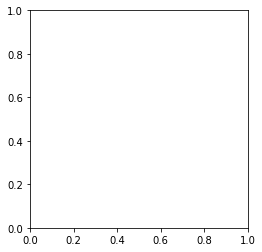

In [54]:
plt.im(training_set[0])

## Further Reading

If you are interested in learning more about variational autoencoders, here is what I recommend:
* [Sticking the Landing](https://arxiv.org/abs/1703.09194). As mentioned above, it explains why the MC loss is used rather than KL divergence.
* [Towards a deeper understanding of VAEs](https://arxiv.org/abs/1702.08658v1), which explains in part why the blurry images above occur. I had originally believed it was a result of using an inappropriate loss function, but it turns out that this is actually caused by the decoder using the average reconstruction. In our notation, this means the decoder is learning to return $\mathbb{E}_{p(x|z)}[x]$. The paper also discuss how to avoid blurry images.
* [Improved Variational Inference with Inverse Autoregressive Flow](https://arxiv.org/abs/1606.04934v2), which describes how to encode to non-diagonal covariance matrices $\Sigma(x)$ in a computationally straight-forward way. Another approach based on this paper is offered in [convex combination linear Inverse Autoregressive Flow](https://arxiv.org/abs/1706.0232), which is more easily applied.
* It's also worth pointing out that you can use *several* latent variables. There are two variants I'm aware of for this: the Ladder Variational Autoencoder and the Variational Ladder Autoencoder.

## Final Comments

I made this notebook to have an easy way of sharing my interest in VAEs with others. If you find an error or have any suggestions, please let me know.